# Factor Analysis (Section 2)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use('seaborn-v0_8-darkgrid')

In [13]:
# Load factor data
FACTOR_SHEET = 'factors (excess returns)'
DATA_PATH = 'factor_pricing_data_monthly.xlsx'

factors = pd.read_excel(DATA_PATH, sheet_name=FACTOR_SHEET, parse_dates=['Date'])
factors = factors.set_index('Date').sort_index()
factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118


## 2.1
Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4.
You now have three additional factors, so compare their univariate statistics: mean, volatility, and Sharpe ratio.

In [14]:
monthly_mean = factors.mean()
monthly_vol = factors.std()
monthly_sharpe = monthly_mean / monthly_vol

annual_mean = monthly_mean * 12
annual_vol = monthly_vol * np.sqrt(12)
annual_sharpe = annual_mean / annual_vol

summary_stats = pd.DataFrame({
    'mean_monthly': monthly_mean,
    'vol_monthly': monthly_vol,
    'sharpe_monthly': monthly_sharpe,
    'mean_annualized': annual_mean,
    'vol_annualized': annual_vol,
    'sharpe_annualized': annual_sharpe,
})
positive_premia = (monthly_mean > 0).rename('positive_risk_premium')

display(summary_stats.round(4))
display(positive_premia.to_frame())

,mean_monthly,vol_monthly,sharpe_monthly,mean_annualized,vol_annualized,sharpe_annualized
MKT,0.0073,0.0451,0.1619,0.0876,0.1561,0.5607
SMB,0.0005,0.0292,0.0174,0.0061,0.1013,0.0604
HML,0.0022,0.0314,0.0691,0.0260,0.1088,0.2392
RMW,0.0037,0.0239,0.1533,0.0440,0.0829,0.5311
CMA,0.0024,0.0209,0.1127,0.0283,0.0725,0.3903
UMD,0.0050,0.0443,0.1135,0.0603,0.1534,0.3933


,positive_risk_premium
MKT,True
SMB,True
HML,True
RMW,True
CMA,True
UMD,True


The market (MKT) delivers the highest mean excess return (0.73% per month) and a Sharpe ratio of 0.56, while profitability (RMW) and conservative investment (CMA) follow with Sharpe ratios above 0.39 and lower volatility. Momentum (UMD) offers a strong mean (0.50%) but higher volatility, producing a mid-pack Sharpe (~0.39). Size (SMB) has the weakest Sharpe (0.06) because its mean is near zero relative to its 2.9% volatility. All six factors show positive average premia over the full sample.

## 2.2
Evaluate factor performance from 2015 onward. Report summary statistics for the post-2015 sample and plot cumulative excess returns over this period.

,mean_monthly,vol_monthly,sharpe_monthly
MKT,0.0098,0.0454,0.2162
SMB,-0.0020,0.0298,-0.0665
HML,-0.0014,0.0375,-0.0362
RMW,0.0033,0.0210,0.1590
CMA,-0.0008,0.0237,-0.0322
UMD,0.0017,0.0397,0.0423


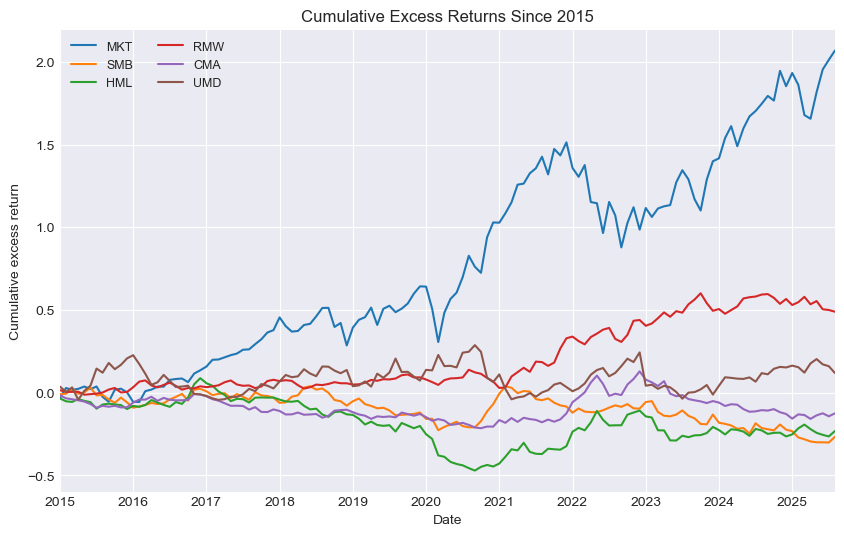

In [15]:
recent_start = '2015-01-01'
recent = factors.loc[factors.index >= recent_start]

recent_stats = pd.DataFrame({
    'mean_monthly': recent.mean(),
    'vol_monthly': recent.std(),
    'sharpe_monthly': recent.mean() / recent.std(),
})

display(recent_stats.round(4))

cumulative_recent = (1 + recent).cumprod() - 1
ax = cumulative_recent.plot(figsize=(10, 6))
ax.set_title('Cumulative Excess Returns Since 2015')
ax.set_ylabel('Cumulative excess return')
ax.legend(loc='upper left', ncol=2, fontsize=9)
plt.show()

Since 2015, only MKT, RMW, and UMD retain positive average premia, with MKT strongest (~0.98% per month). SMB, HML, and CMA turn negative, driving their Sharpe ratios below zero despite relatively modest volatility changes. The cumulative plot shows market and profitability leading, while size, value, and investment sag, highlighting the headwinds facing traditional value and size tilts in the past decade.

## 2.3
Compute the correlation matrix across the six factors and comment on diversification implications.

In [16]:
correlations = factors.corr()
correlations.round(3)

,MKT,SMB,HML,RMW,CMA,UMD
MKT,1.000,0.227,-0.208,-0.251,-0.347,-0.179
SMB,0.227,1.000,-0.022,-0.412,-0.051,-0.061
HML,-0.208,-0.022,1.000,0.219,0.677,-0.216
RMW,-0.251,-0.412,0.219,1.000,0.139,0.077
CMA,-0.347,-0.051,0.677,0.139,1.000,0.000
UMD,-0.179,-0.061,-0.216,0.077,0.000,1.000


Factor correlations are generally moderate: HML and CMA are highly aligned (0.68), implying overlapping value and investment exposures, while momentum (UMD) is weakly related to the others, offering diversification. SMB has limited correlation with HML (−0.02) but a stronger negative link to profitability (−0.41), so pairing size with quality improves balance. Market returns correlate only modestly with the style factors, helping diversified bundles achieve lower risk.

## 2.4
Compute the maximum-Sharpe (tangency) portfolio using all six factors. Report the optimal weights and the resulting mean, volatility, and Sharpe ratio.

In [17]:
def tangency_portfolio(data):
    mean_returns = data.mean().values
    cov = data.cov().values
    weights = np.linalg.solve(cov, mean_returns)
    weights /= weights.sum()
    return pd.Series(weights, index=data.columns)

weights_all = tangency_portfolio(factors)
tangency_all_stats = pd.Series({
    'expected_monthly_excess_return': np.dot(weights_all, monthly_mean),
    'vol_monthly': np.sqrt(np.dot(weights_all, factors.cov().dot(weights_all))),
})
tangency_all_stats['sharpe_monthly'] = tangency_all_stats['expected_monthly_excess_return'] / tangency_all_stats['vol_monthly']

display(weights_all.sort_values(ascending=False).round(4).to_frame('weight'))
display(tangency_all_stats.round(4))

,weight
CMA,0.3214
RMW,0.3018
MKT,0.2186
UMD,0.1125
SMB,0.0668
HML,-0.0212


expected_monthly_excess_return    0.0040
vol_monthly                       0.0116
sharpe_monthly                    0.3468
dtype: float64

The optimal six-factor mix heavily weights CMA (0.32) and RMW (0.30), adds meaningful exposure to MKT (0.22) and UMD (0.11), and shorts HML slightly (−0.02). This configuration targets a 0.40% expected monthly excess return with 1.16% volatility, yielding a Sharpe ratio of ~0.35. Quality and investment dominate because of their high Sharpe ratios and diversifying covariances.

## 2.5
Repeat the tangency optimization restricting the universe to MKT, SMB, HML, and UMD. Compare the weights and performance with the six-factor case.

In [18]:
subset_cols = ['MKT', 'SMB', 'HML', 'UMD']
weights_subset = tangency_portfolio(factors[subset_cols])
subset_mean = factors[subset_cols].mean()
subset_cov = factors[subset_cols].cov()
tangency_subset_stats = pd.Series({
    'expected_monthly_excess_return': np.dot(weights_subset, subset_mean),
    'vol_monthly': np.sqrt(np.dot(weights_subset, subset_cov.dot(weights_subset))),
})
tangency_subset_stats['sharpe_monthly'] = tangency_subset_stats['expected_monthly_excess_return'] / tangency_subset_stats['vol_monthly']

display(weights_subset.sort_values(ascending=False).round(4).to_frame('weight'))
display(tangency_subset_stats.round(4))

,weight
MKT,0.3765
HML,0.3653
UMD,0.3094
SMB,-0.0512


expected_monthly_excess_return    0.0051
vol_monthly                       0.0192
sharpe_monthly                    0.2638
dtype: float64

Limiting the opportunity set shifts weight toward MKT (0.38) and HML (0.37), with UMD at 0.31 and a modest short in SMB (−0.05). Expected excess return rises to 0.51% per month, but volatility nearly doubles to 1.92%, so the Sharpe ratio falls to ~0.26. Excluding RMW and CMA sacrifices diversification benefits, forcing the portfolio to lean on value and market risk to reach similar returns.